# Pipeline Submisson -Microsoft Security Incident Prediction
Can you predict the next big security incident before it happens?

https://www.kaggle.com/datasets/Microsoft/microsoft-security-incident-prediction

**Submitted by: Shahar Tavor and Liran Eliav**

In [360]:
#pip install pycountry


In [361]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pycountry
import seaborn as sns
from collections import Counter
import json


In [461]:
pd.set_option('display.float_format', '{:,.4f}'.format)

In [363]:
"""
import kagglehub
path = kagglehub.dataset_download("Microsoft/microsoft-security-incident-prediction")
print("Path to dataset files:", path)
"""

'\nimport kagglehub\npath = kagglehub.dataset_download("Microsoft/microsoft-security-incident-prediction")\nprint("Path to dataset files:", path)\n'

## Meta Data:

In [364]:
df_train = pd.read_csv("GUIDE_Train.csv")
df_test = pd.read_csv("GUIDE_Train.csv")

### Data size:


In [365]:
print(f"df train shape: {df_train.shape} df test shape: {df_test.shape}")

df train shape: (9516837, 45) df test shape: (9516837, 45)


In [366]:
df_train.head(3)

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630


### Data types:


#### Use describe:

In [367]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  EmailClusterId      floa

In [368]:
def describe_df(df):
    rows_count = df.shape[0]
    for col in df.columns:
        print(f"--- Description for column: {col} ---")
        desc = df[col].describe()
        print(desc)
        print()

count: number of non-null entries \
mean: average \
std: standard deviation \
min: minimum \
25%, 50%, 75%: percentiles (quartiles) \
max: maximum



### Missing data:

In [369]:
missing_summary = df_train.isnull().sum().to_frame(name='Missing Count')
missing_summary['Missing %'] = (missing_summary['Missing Count'] / len(df_train)) * 100
print(missing_summary[missing_summary['Missing Count'] > 0])


                   Missing Count  Missing %
MitreTechniques          5468386         57
IncidentGrade              51340          1
ActionGrouped            9460773         99
ActionGranular           9460773         99
EmailClusterId           9420025         99
ThreatFamily             9441956         99
ResourceType             9509762        100
Roles                    9298686         98
AntispamDirection        9339535         98
SuspicionLevel           8072708         85
LastVerdict              7282572         77


In the case of MitreTechniques, its meaningful information, since not having Mitre can connect to clean event.

In [370]:
df_train['MitreTechniques'] = df_train['MitreTechniques'].fillna('None')

In the case of IncidentGrade, we want to use this column as labels,so we will drop the nan:

In [371]:
df_train = df_train.dropna(subset=['IncidentGrade'])
df_train['IncidentGrade'].isna().sum()

0

The rest of the columns, have too many nan, so we will drop them:

In [372]:
columns_to_drop = [
    'ActionGrouped', 'ActionGranular', 'EmailClusterId',
    'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection',
    'SuspicionLevel', 'LastVerdict'
]
df_train = df_train.drop(columns=columns_to_drop)


In [373]:
df_train.shape

(9465497, 36)

### Balance the df:

Labels of events are the column 'IncidentGrade':

In [374]:
n_per_class = 100_000

In [475]:
print("Before balance")
print(df_train['IncidentGrade'].value_counts())

df_balanced = pd.concat([
    df_train[df_train['IncidentGrade'] == 'BenignPositive'].sample(n=n_per_class, random_state=42),
    df_train[df_train['IncidentGrade'] == 'TruePositive'].sample(n=n_per_class//2, random_state=42),
    df_train[df_train['IncidentGrade'] == 'FalsePositive'].sample(n=n_per_class//2, random_state=42)
])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print()
print("After balance")
print(df_balanced['IncidentGrade'].value_counts())

Before balance
IncidentGrade
BenignPositive    4110817
TruePositive      3322713
FalsePositive     2031967
Name: count, dtype: int64

After balance
IncidentGrade
BenignPositive    100000
TruePositive       50000
FalsePositive      50000
Name: count, dtype: int64


In [476]:
df_balanced.shape

(200000, 36)

### Special values:


In [477]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 36 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  200000 non-null  int64 
 1   OrgId               200000 non-null  int64 
 2   IncidentId          200000 non-null  int64 
 3   AlertId             200000 non-null  int64 
 4   Timestamp           200000 non-null  object
 5   DetectorId          200000 non-null  int64 
 6   AlertTitle          200000 non-null  int64 
 7   Category            200000 non-null  object
 8   MitreTechniques     200000 non-null  object
 9   IncidentGrade       200000 non-null  object
 10  EntityType          200000 non-null  object
 11  EvidenceRole        200000 non-null  object
 12  DeviceId            200000 non-null  int64 
 13  Sha256              200000 non-null  int64 
 14  IpAddress           200000 non-null  int64 
 15  Url                 200000 non-null  int64 
 16  Ac

Fix timestamp:
We can see the timestamp is object type

In [478]:
# convert to datetime 
df_balanced["Timestamp"] = pd.to_datetime(df_train["Timestamp"], errors='coerce')
df_balanced["Timestamp"].head(3)

0   2024-06-04 06:05:15+00:00
1   2024-06-14 03:01:25+00:00
2   2024-06-13 04:52:55+00:00
Name: Timestamp, dtype: datetime64[ns, UTC]

In [479]:
# check if sorted
is_sorted = df_balanced["Timestamp"].is_monotonic_increasing
print("Is Timestamp sorted?", is_sorted)


Is Timestamp sorted? False


In [480]:
#df_balanced = df_balanced.sort_values("Timestamp").reset_index(drop=True)


In [481]:
ip_freq = df_balanced['IpAddress'].value_counts()
ip_freq

IpAddress
360606    156019
0            213
2            151
8            149
1            142
           ...  
23964          1
110604         1
47516          1
7816           1
84587          1
Name: count, Length: 23104, dtype: int64

We will use the freq of ip:

In [482]:
df_balanced['IpFreq'] = df_balanced['IpAddress'].map(ip_freq)
df_balanced['Ip_is_360606'] = (df_balanced['IpAddress'] == 360606).astype(int)
df_balanced = df_balanced.drop(columns=['IpAddress'])

## Data Statistics 

#### Country code:

In [483]:
code_to_country = {}
for country in pycountry.countries:
    try:
        code_to_country[int(country.numeric)] = country.name
    except:
        pass

country_map = df_balanced['CountryCode'].map(code_to_country).fillna('Unknown')
country_counts = country_map.value_counts()

In [484]:
#needs to convert to pie

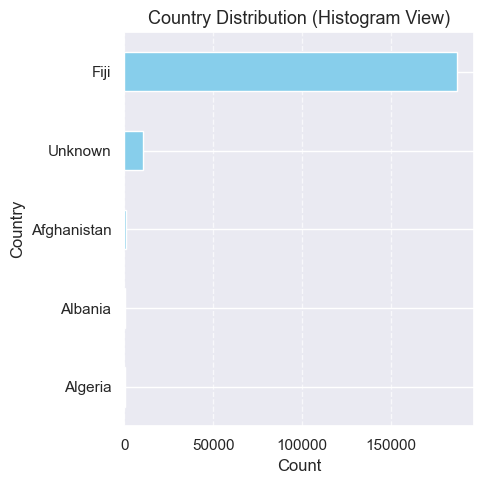

In [485]:
top_n = 5
top_countries = country_counts[:top_n]
other_count = country_counts[top_n:].sum()
plot_country = pd.concat([top_countries])
plt.figure(figsize=(5, 5))
plot_country.sort_values().plot(kind='barh', color='skyblue')
plt.title("Country Distribution (Histogram View)", fontsize=13)
plt.xlabel("Count")
plt.ylabel("Country")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Category and EntityType:

In [486]:
def hist_objest(cat_column):
    column_counts = df_balanced[cat_column].value_counts()
    plt.figure(figsize=(10, 5))
    column_counts.plot(kind='barh', color='skyblue')
    plt.title(f"{cat_column} Distribution")
    plt.xlabel("Count")
    plt.ylabel(f"{cat_column}")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

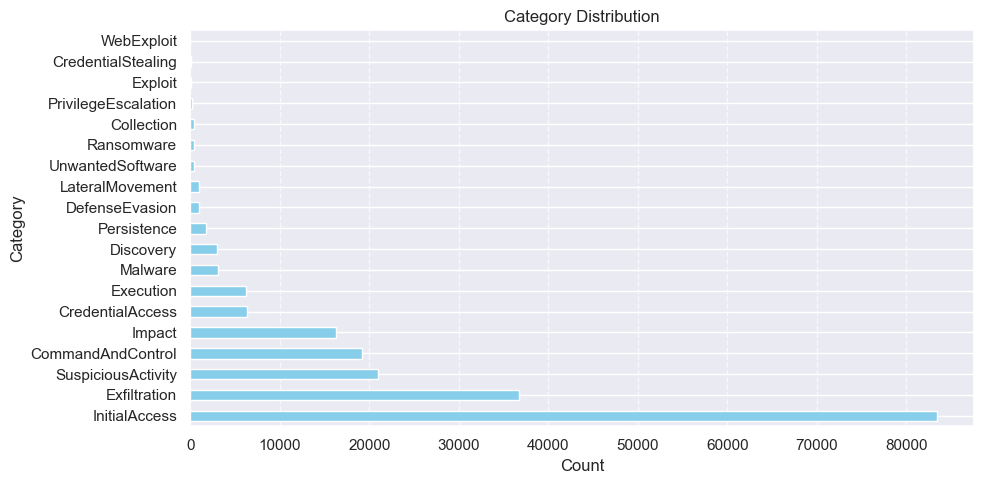

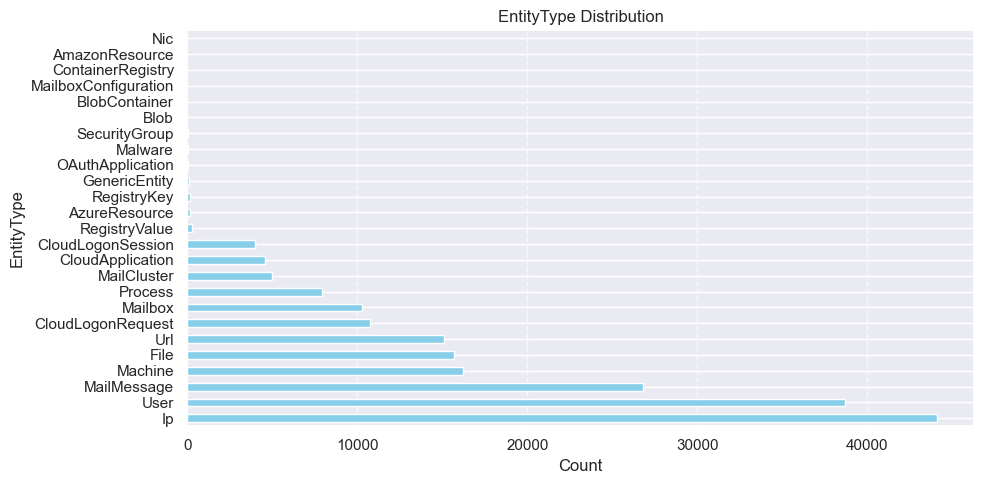

In [487]:
hist_objest("Category")
hist_objest("EntityType")

Map to numeric:

In [488]:
def map_object(cat_column):
    le = LabelEncoder()
    df_balanced[f"{cat_column}_Encode"] = le.fit_transform(df_balanced[cat_column])
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    reverse_mapping = {v: k for k, v in label_mapping.items()} 
    print(label_mapping)
    return reverse_mapping

In [489]:
reverse_mapping_cat = map_object("Category")

{'Collection': 0, 'CommandAndControl': 1, 'CredentialAccess': 2, 'CredentialStealing': 3, 'DefenseEvasion': 4, 'Discovery': 5, 'Execution': 6, 'Exfiltration': 7, 'Exploit': 8, 'Impact': 9, 'InitialAccess': 10, 'LateralMovement': 11, 'Malware': 12, 'Persistence': 13, 'PrivilegeEscalation': 14, 'Ransomware': 15, 'SuspiciousActivity': 16, 'UnwantedSoftware': 17, 'WebExploit': 18}


In [490]:
reverse_mapping_entity = map_object("EntityType")

{'AmazonResource': 0, 'AzureResource': 1, 'Blob': 2, 'BlobContainer': 3, 'CloudApplication': 4, 'CloudLogonRequest': 5, 'CloudLogonSession': 6, 'ContainerRegistry': 7, 'File': 8, 'GenericEntity': 9, 'Ip': 10, 'Machine': 11, 'MailCluster': 12, 'MailMessage': 13, 'Mailbox': 14, 'MailboxConfiguration': 15, 'Malware': 16, 'Nic': 17, 'OAuthApplication': 18, 'Process': 19, 'RegistryKey': 20, 'RegistryValue': 21, 'SecurityGroup': 22, 'Url': 23, 'User': 24}


#### EvidenceRole:

EvidenceRole indicates the function of an entity (like a device, user) in the context of a security incident\
Impacted entities = primary victims \
Related entities = secondary signals

In [491]:
df_balanced['EvidenceRole'].value_counts()

EvidenceRole
Related     107062
Impacted     92938
Name: count, dtype: int64

Since its binary:

In [492]:
df_balanced['EvidenceRole'] = df_balanced['EvidenceRole'].map({'Related': 0, 'Impacted': 1})

#### MitreTechniques:

New feature - count of techniques per row

In [493]:
df_balanced['MitreCount'] = df_balanced['MitreTechniques'].apply(
    lambda x: 0 if x == 'None' else len(x.split(';'))
)
print(f"Max tech: {df_balanced['MitreCount'].max()}, min: {df_balanced['MitreCount'].min()}")

Max tech: 61, min: 0


In [494]:
"""
df_balanced['HasMitre'] = df_balanced['MitreTechniques'].apply(
    lambda x: 0 if x == 'None' else 1
)
"""

"\ndf_balanced['HasMitre'] = df_balanced['MitreTechniques'].apply(\n    lambda x: 0 if x == 'None' else 1\n)\n"

Map tech code to name:

In [495]:
with open("enterprise-attack.json", "r") as f:
    mitre_data = json.load(f)

In [496]:
techniques = {
    obj['external_references'][0]['external_id']: obj['name']
    for obj in mitre_data['objects']
    if obj.get('type') == 'attack-pattern' and 'external_references' in obj
}
for i, (tech, name) in enumerate(techniques.items()):
    print(f"{tech}: {name}")
    if i == 2:
        break

T1055.011: Extra Window Memory Injection
T1053.005: Scheduled Task
T1205.002: Socket Filters


In [499]:
all_techs = df_balanced['MitreTechniques'].apply(lambda x: [] if x == 'None' else x.split(';'))
tech_rows = []

for i, (mitres, label) in enumerate(zip(all_techs, df_balanced['IsIncident'])):
    for t in mitres:
        tech_rows.append((t, label))

# Make DataFrame and compute stats
import pandas as pd
tech_df = pd.DataFrame(tech_rows, columns=['Technique', 'IsIncident'])
summary = tech_df.groupby('Technique')['IsIncident'].agg(['count', 'mean'])
summary.columns = ['RowCount', 'IncidentRate']
summary = summary.sort_values('IncidentRate', ascending=False)

# View rare techniques with high incident rate
summary[summary['RowCount'] < 100].head(10)


,RowCount,IncidentRate
Technique,,
T1056.003,1,1.0000
T1578,1,1.0000
T0858,1,1.0000
T0855,1,1.0000
T1071.003,1,1.0000
T1027.003,1,1.0000
T0843,1,1.0000
T1584,14,0.9286
T1110.004,24,0.9167


In [397]:
# Split all techniques
all_techs = df_balanced['MitreTechniques'].apply(lambda x: [] if x == 'None' else x.split(';'))
flat_list = [tech for sublist in all_techs for tech in sublist]
top_10_ids = [tech for tech, _ in Counter(flat_list).most_common(10)]

top_10_named = {tid: techniques.get(tid, tid) for tid in top_10_ids}

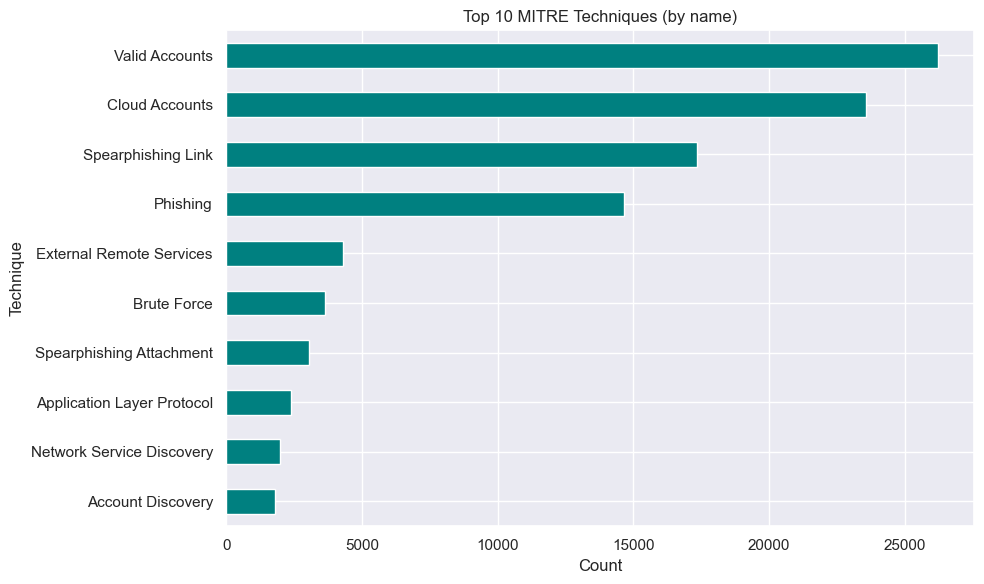

In [398]:
named_counts = {top_10_named[tid]: flat_list.count(tid) for tid in top_10_ids}

plt.figure(figsize=(10, 6))
pd.Series(named_counts).sort_values().plot(kind='barh', color='skyblue')
plt.title("Top 10 MITRE Techniques (by name)")
plt.xlabel("Count")
plt.ylabel("Technique")
plt.tight_layout()
plt.show()


Convert top10 to new features:

In [399]:
for tech_id in top_10_ids:
    name = top_10_named[tech_id].replace(' ', '_')  # safe column name
    df_balanced[f'Mitre_{name}'] = df_balanced['MitreTechniques'].apply(
        lambda x: int(tech_id in x.split(';')) if x != 'None' else 0
    )
df_balanced = df_balanced.drop(columns=['MitreTechniques'])


In [498]:
df_balanced['IsIncident'] = df_balanced['IncidentGrade'].map({
    'TruePositive': 1,
    'FalsePositive': 0,
    'BenignPositive': 0
})
df_balanced = df_balanced.drop(columns=['IncidentGrade'])

In [410]:
def plot_incident_distribution(df, column, top_n=10):
    # Filter top N values in the column
    top_vals = df[column].value_counts().nlargest(top_n).index
    filtered = df[df[column].isin(top_vals)]

    plt.figure(figsize=(10, 6))
    sns.countplot(data=filtered, x=column, hue='IsIncident', palette={1: 'red', 0: 'blue'})
    plt.title(f"Distribution of IsIncident by {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(title="IsIncident", labels=["No", "Yes"])
    plt.tight_layout()
    plt.show()


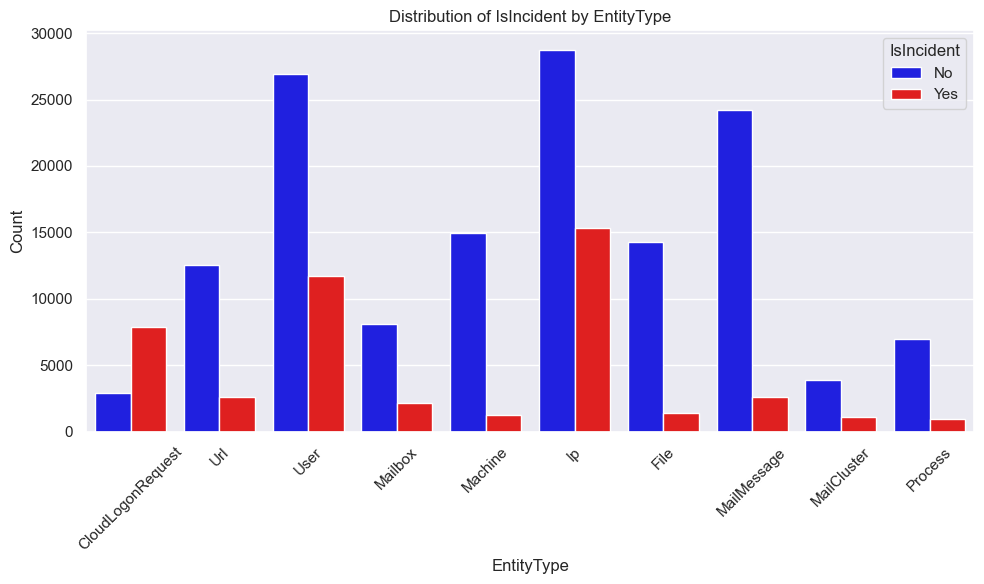

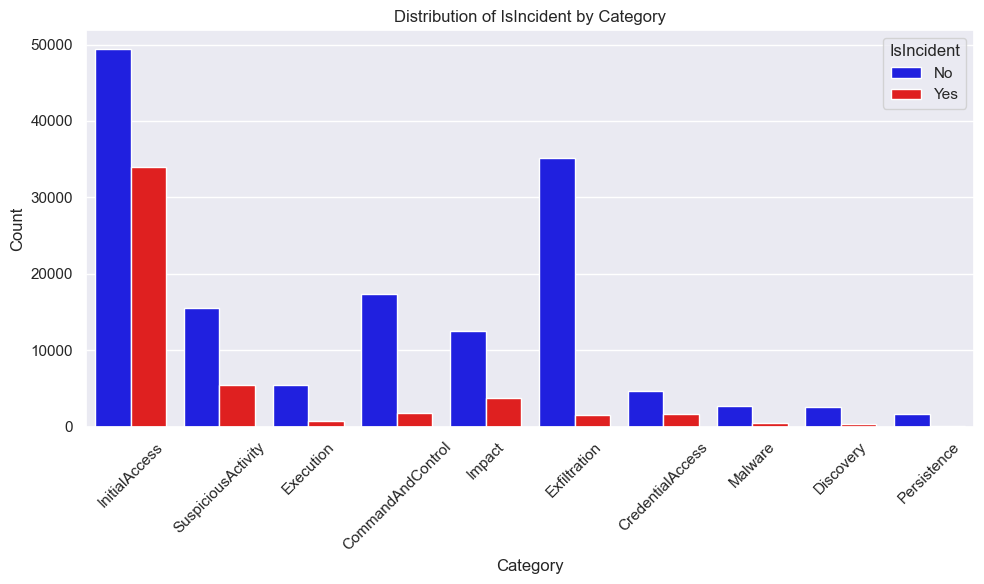

In [451]:
plot_incident_distribution(df_balanced, 'EntityType')
plot_incident_distribution(df_balanced, 'Category')

rate is:
(count_true × 1 + count_false × 0) / count_total 


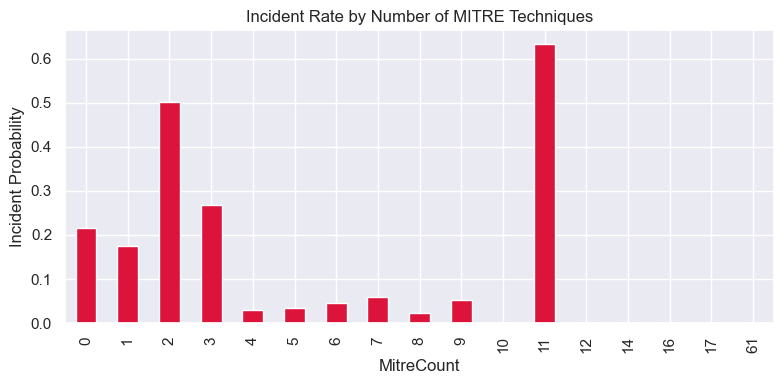

In [467]:
rate = df_balanced.groupby('MitreCount')['IsIncident'].mean()
rate.plot(kind='bar', color='crimson', figsize=(8, 4))
plt.title("Incident Rate by Number of MITRE Techniques")
plt.ylabel("Incident Probability")
plt.xlabel("MitreCount")
plt.tight_layout()
plt.show()


1. Incidents are most frequently associated with Ip and CloudLogonRequest.
2. MitreCount = 2–3  and 11 is most predictive of true incidents




In [ ]:
#df_balanced['MitreRiskFlag'] = df_balanced['MitreCount'].apply(lambda x: 1 if x in [2, 3, 11] else 0)


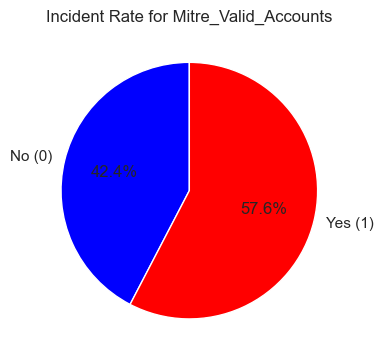

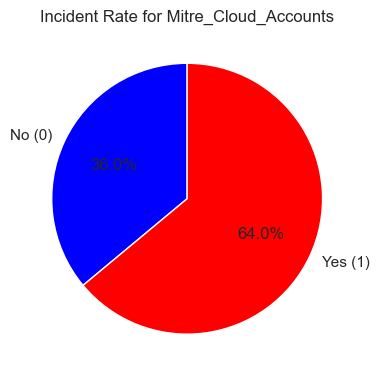

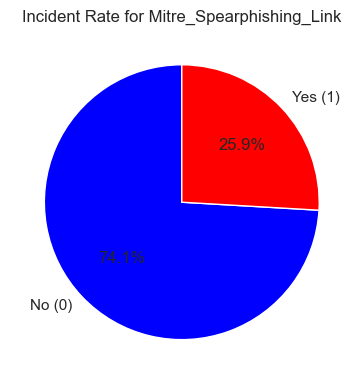

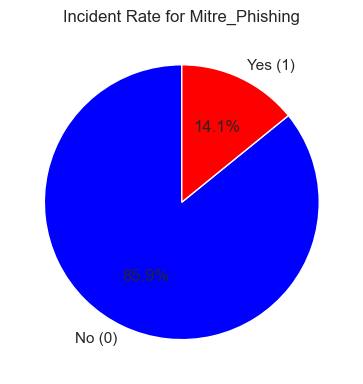

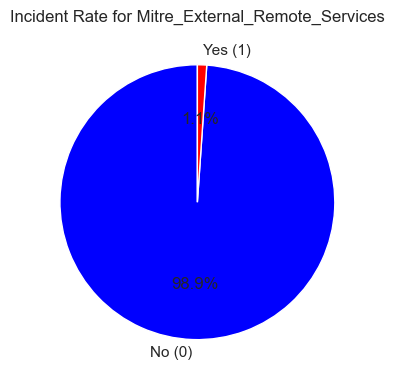

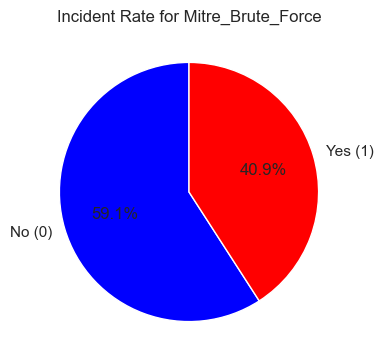

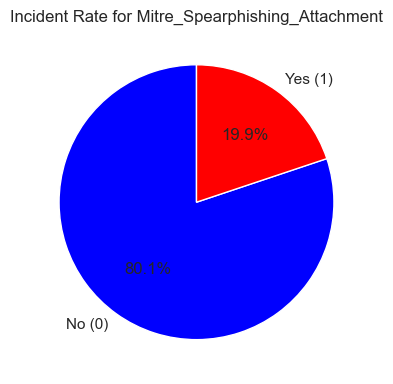

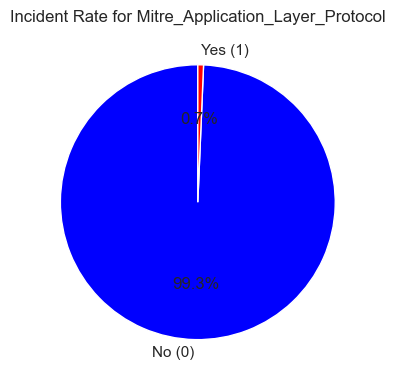

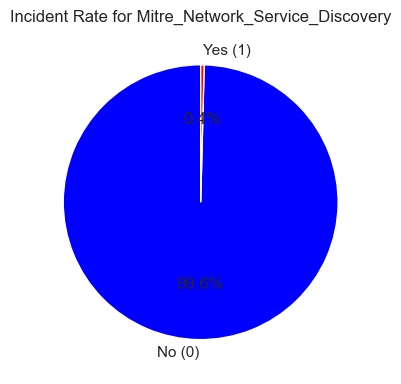

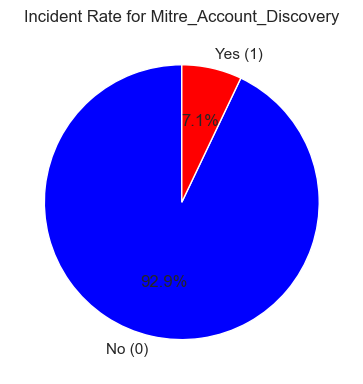

In [469]:

mitre_onehot_cols = [col for col in df_balanced.columns if col.startswith('Mitre_')]

# For each technique, plot a pie
for col in mitre_onehot_cols:
    subset = df_balanced[df_balanced[col] == 1]
    counts = subset['IsIncident'].value_counts().sort_index()

    # Ensure both 0 and 1 are present
    counts = counts.reindex([0, 1], fill_value=0)

    labels = ['No (0)', 'Yes (1)']
    colors = ['blue', 'red']

    plt.figure(figsize=(4, 4))
    plt.pie(
        counts,
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90
    )
    plt.title(f"Incident Rate for {col}")
    plt.tight_layout()
    plt.show()
